In [1]:
# !pip install pandas_datareader

In [2]:
import math
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas_datareader as pdr
from datetime import datetime, timedelta

In [3]:
#Get the stock
ticker = 'MU'
stock ="Micron Technology Inc"
# Time step n days, here we will use n  days historical data to predict next day closing
ts_points = 120
# train_data[0:60,0]  

today = datetime.today()
# start_date ='2016-01-01'
start_date = (today - timedelta(days=5*365) ).strftime('%Y-%m-%d')

end_date   = today.strftime('%Y-%m-%d')
stock_df = pdr.DataReader(ticker, data_source="yahoo", start=start_date, end=end_date)

In [4]:
# Date is an index but to be sure , let's sort
stock_df = stock_df.sort_index(ascending=True)
stock_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-10-26,17.930000,17.200001,17.299999,17.639999,23610500.0,17.615376
2016-10-27,17.900000,17.400000,17.820000,17.530001,21198300.0,17.505531
2016-10-28,17.670000,17.100000,17.600000,17.200001,20832400.0,17.175991
2016-10-31,17.760000,17.160000,17.540001,17.160000,23267600.0,17.136047
2016-11-01,17.410000,16.580000,17.200001,16.980000,27146100.0,16.956297
...,...,...,...,...,...,...
2021-10-19,67.889999,66.639999,67.370003,67.570000,16930300.0,67.570000
2021-10-20,69.199997,67.010002,67.199997,68.269997,19457800.0,68.269997
2021-10-21,68.699997,67.669998,67.949997,68.639999,11140700.0,68.639999


In [5]:
# check for nulls
stock_df.isna().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [6]:
# Get shape
stock_df.shape

(1258, 6)

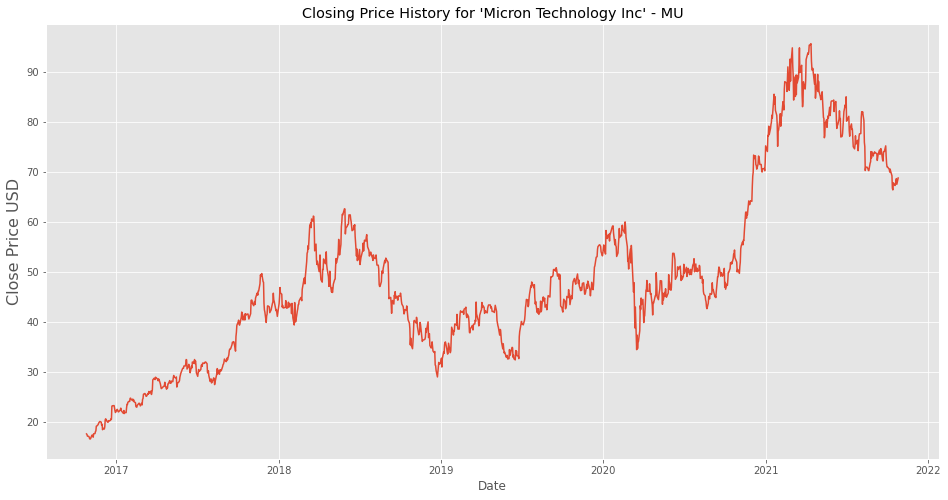

In [7]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title (f"Closing Price History for '{stock}' - {ticker}")
plt.plot(stock_df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD', fontsize=16)
plt.savefig('Saved_Models/Images/his_'+ticker+'.png')
plt.show()

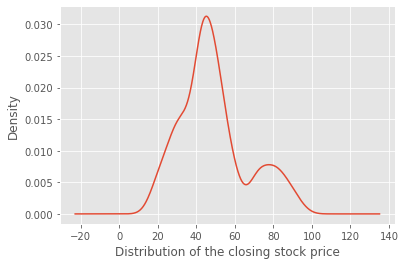

In [8]:
stock_df['Close'].plot.density()
plt.xlabel('Distribution of the closing stock price')
plt.savefig('Saved_Models/Images/den_'+ticker+'.png')
plt.show()

In [9]:
# DF with only close
TSdata_df = stock_df.filter(['Close'])
TSdata_arr = TSdata_df.values # this creates an array of Close Price
TSdata_arr

array([[17.63999939],
       [17.53000069],
       [17.20000076],
       ...,
       [68.63999939],
       [67.51000214],
       [68.76000214]])

In [10]:
# Scale the Data
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(TSdata_arr)
#scaled_data

In [11]:
training_data_len = math.ceil(len(TSdata_arr) * 0.75)
training_data_len

944

In [12]:
# Created scaled training dataset
train_data = scaled_data[0:training_data_len]
train_data.shape

(944, 1)

In [13]:
# Split
X_train = []
y_train = []

for i in range(ts_points, len(train_data)):
    X_train.append(train_data[i-ts_points:i,0])
    y_train.append(train_data[i,0])
    # if i <= ts_points+3:
    #     print(X_train)
    #     print(y_train)
    #     print()


In [14]:
# convert X_train and y_train to numpy arrays for LSTM
X_train, y_train = np.array(X_train), np.array(y_train)

In [15]:
print (X_train.shape)
print (y_train.shape)

(824, 120)
(824,)


In [16]:
# LSTM network expects a 3D input (No_of_Samples, number of time steps, and number of features) no_of_features = 1 (Close)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(824, 120, 1)

In [17]:
training_data_len - ts_points

824

In [18]:
# hidden_nodes = int(2/3 * (X_train.shape[1] * 1))
# print(f"The number of hidden nodes is {hidden_nodes}.")

In [19]:
# LSTM MOdel
model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
# model.add(tf.keras.layers.LSTM(50, return_sequences=False))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(25))
# model.add(tf.keras.layers.Dense(1))
# model.summary()


In [20]:

# BEST FOR MU#
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))
model.summary()

# model.fit(X_train, y_train, batch_size=64, epochs=50

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='adam', loss='mean_squared_error')
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [22]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size=64

os.makedirs("chk_points/", exist_ok=True)
chkpoint_path="chk_points/weights.{epoch}.hdf5"

# Create chk points
chkpt_callback = ModelCheckpoint(filepath=chkpoint_path,
                              verbose=1,
                              save_weights_only=True,
                              save_freq="epoch",
                              period=5)

chkpoint_path = "chk_points/cp-{epoch:04d}.ckpt"
chkpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=chkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)                    

model.save_weights(chkpoint_path.format(epoch=0))    


In [23]:
# training_data_len
# scaled_data

In [24]:
# model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_split=0.43, callbacks=[chkpt_callback])
model.fit(X_train, y_train, batch_size=64, epochs=50)

Epoch 1/50
13/13 [==============================] - 7s 121ms/step - loss: 0.0279
Epoch 2/50
13/13 [==============================] - 2s 118ms/step - loss: 0.0044
Epoch 3/50
13/13 [==============================] - 1s 112ms/step - loss: 0.0031
Epoch 4/50
13/13 [==============================] - 1s 107ms/step - loss: 0.0022
Epoch 5/50
13/13 [==============================] - 2s 117ms/step - loss: 0.0019
Epoch 6/50
13/13 [==============================] - 2s 120ms/step - loss: 0.0017
Epoch 7/50
13/13 [==============================] - 1s 100ms/step - loss: 0.0015
Epoch 8/50
13/13 [==============================] - 1s 95ms/step - loss: 0.0015
Epoch 9/50
13/13 [==============================] - 1s 104ms/step - loss: 0.0014
Epoch 10/50
13/13 [==============================] - 1s 97ms/step - loss: 0.0014
Epoch 11/50
13/13 [==============================] - 1s 98ms/step - loss: 0.0014
Epoch 12/50
13/13 [==============================] - 1s 98ms/step - loss: 0.0013
Epoch 13/50
13/13 [==========

In [25]:
model.save('Saved_Models/Model_'+ticker+'.h5')

In [26]:
# test_data = scaled_data[training_data_len:]

# Bring in the last 'ts_points' (60 values) from training set so when X_test is used to predict , predictions have same shape as Y_test
# The for loop starts with 'ts_points' thatbmeans the resultant array will have 60 less rows
test_data = scaled_data[training_data_len-ts_points:]
# test_data[0:60,0]


In [27]:
X_test = []
y_test = TSdata_arr[training_data_len:]
for i in range(ts_points, len(test_data)):
    X_test.append(test_data[i-ts_points:i,0])


In [28]:
# convert the data to a numpy array to use it in LSTM MODEL
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1], 1))

In [29]:
from sklearn.metrics import mean_squared_error

In [30]:
# Models predicted price for X_train
predictions_tr = model.predict(X_train)
predictions_tr = scaler.inverse_transform(predictions_tr)

y_train_tr =  scaler.inverse_transform(y_train.reshape(-1,1))
rmse_tr = math.sqrt(mean_squared_error(y_train_tr, predictions_tr))
rmse_tr

1.887219590798326

In [31]:
# Models predicted price for X_test
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [32]:
y_test.shape, predictions.shape

((314, 1), (314, 1))

In [33]:
# RMSE to check accuracy

rmse = math.sqrt(mean_squared_error(y_test, predictions))
rmse

3.871759328268361

In [34]:
# Plot
train = TSdata_df[:training_data_len]
actual = TSdata_df[training_data_len:]
actual['Predictions'] = predictions
actual

<ipython-input-34-bb86776ae978>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['Predictions'] = predictions


,Close,Predictions
Date,,
2020-07-29,50.389999,51.183060
2020-07-30,50.740002,50.834885
2020-07-31,50.060001,50.626171
2020-08-03,50.389999,50.369724
2020-08-04,51.299999,50.225582
...,...,...
2021-10-19,67.570000,65.493782
2021-10-20,68.269997,65.674164
2021-10-21,68.639999,66.084618


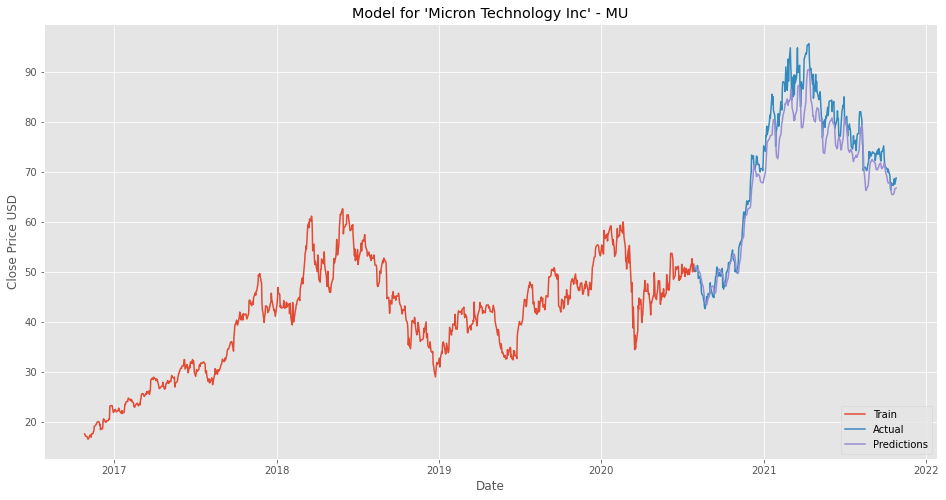

In [35]:
plt.figure(figsize=(16,8))
plt.title(f"Model for '{stock}' - {ticker}")
plt.xlabel("Date")
plt.ylabel("Close Price USD")
plt.plot(train['Close'])
plt.plot(actual[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.savefig('Saved_Models/Images/'+ticker+'.png')
plt.show()

# TEST

In [36]:
# for predictions add 100 extra days to make sure it has more than ts_points to make up for missing days (weekends and holidays)

fetch_days = ts_points + 100    

sd =  today - timedelta(days=fetch_days)
sd = sd.strftime('%Y-%m-%d')

ed = today.strftime('%Y-%m-%d')
ed

next_day = (today + timedelta(days=1) ).strftime('%Y-%m-%d')
# next_day

In [37]:
# get the quote
quote = pdr.DataReader(ticker, data_source="yahoo", start=sd, end=ed)
new_df = quote.filter(['Close'])
last_n_days = ts_points
last_n_days_arr = new_df[-last_n_days:].values 

In [38]:
last_n_days_scaled = scaler.transform(last_n_days_arr)
X_test = []
X_test.append(last_n_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1],1))


In [39]:
##########################loading saved model ###############################
new_model = tf.keras.models.load_model('Saved_Models/Model_'+ticker+'.h5')

# Check its architecture
new_model.summary()
nmpred_price = new_model.predict(X_test)
nmpred_price = scaler.inverse_transform(nmpred_price)
nmpred_price = nmpred_price[0][0]
print(f"Predicted Closing price for '{stock}' on {next_day} is {nmpred_price:.4f}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________
Predicted Closing price for 'Micron Technology Inc' on 2021-10-26 is 67.0166


In [40]:
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price = pred_price[0][0]
print(f"Predicted Closing price for '{stock}' on {next_day} is {pred_price:.4f}")

Predicted Closing price for 'Micron Technology Inc' on 2021-10-26 is 67.0166


In [41]:
# verify
d1 = today - timedelta(days=5)
d1 = d1.strftime('%Y-%m-%d')

quote2 = pdr.DataReader(ticker, data_source="yahoo", start=d1)
quote2

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-10-20,69.199997,67.010002,67.199997,68.269997,19457800,68.269997
2021-10-21,68.699997,67.669998,67.949997,68.639999,11140700,68.639999
2021-10-22,69.089996,67.080002,68.510002,67.510002,17885500,67.510002
2021-10-25,71.120003,68.544998,69.620003,68.760002,22548137,68.760002
